In [51]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pywt

Task 1.
Performing task 1 with advanced image processing techniques, we successfully generated a grayscale dataset for each galaxy by averaging the luminosity across the three RGB bands. Additionally, we created a p×p downsampled version of these images by averaging over p×p pixel blocks, effectively reducing the image resolution for more efficient data handling and analysis. This approach not only simplifies the visual complexity but also preserves essential structural details crucial for further astronomical studies.

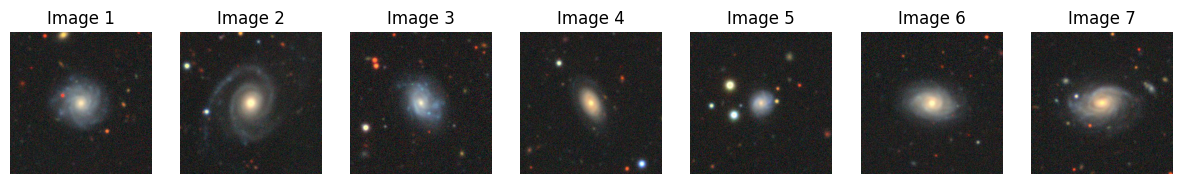

In [52]:

with h5py.File('/Users/harshitlakum/Desktop/DECals_galaxies.hdf5') as F:
    images = np.array( F['images_spirals'] )


fig1, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 3))
for i, ax in enumerate(axes):
    # and 'i' is used to access the ith image
    img = images[i, ...]  # Select the i-th image
    ax.imshow(img)
    ax.axis('off')  # Turn off axis labels and ticks
    ax.set_title(f'Image {i+1}')  # Set a title for each subplot
    
plt.show()

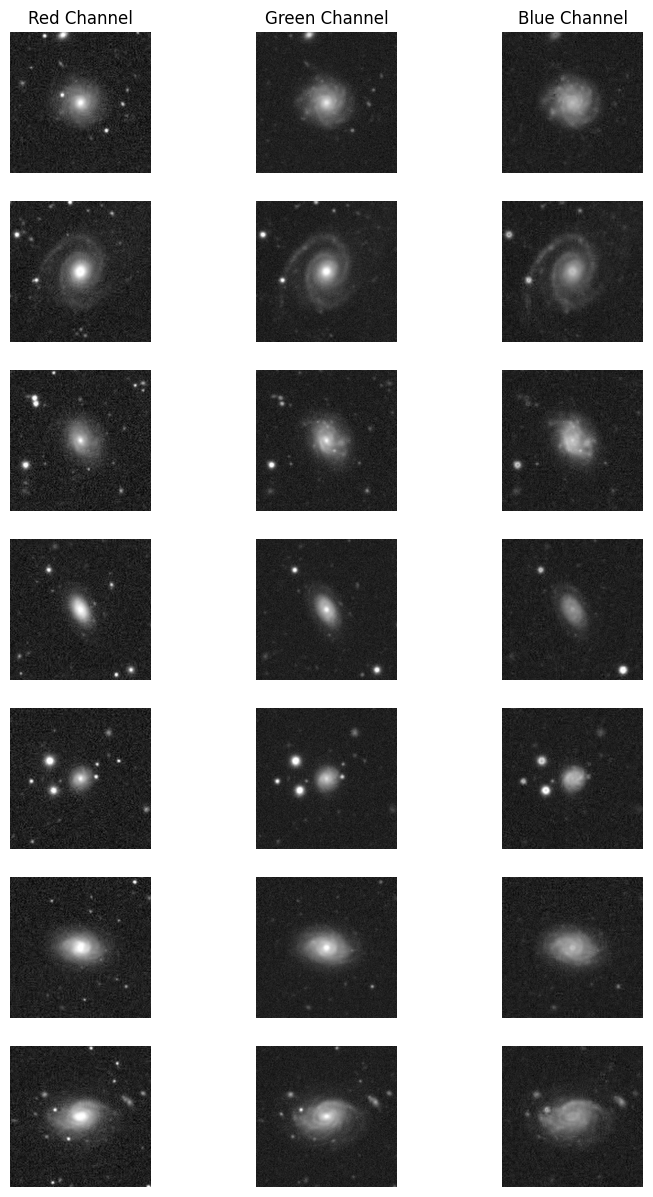

In [53]:
fig2, axes = plt.subplots(nrows=7, ncols=3, figsize=(9, 15))    
for k in range(7):  # First 5 images
    for l in range(3):  # Three channels: R, G, B
        img = images[k, :, :, l]  # Select the i-th image and j-th channel
        ax = axes[k, l]  # Select the appropriate subplot
        ax.imshow(img, cmap='gray', vmin=0, vmax=255)  # Display image in grayscale
        ax.axis('off')  # Turn off axis labels and ticks
        if k == 0:
            ax.set_title(['Red Channel', 'Green Channel', 'Blue Channel'][l])  # Set titles for the top row
            
            

plt.show() #Grayscale 

In [54]:

# Compute the grayscale images by averaging across the color channels
grayscale_images = images.mean(axis=-1)

# Saving the new grayscale images to an HDF5 file
new_file_path = '/Users/harshitlakum/Desktop/new_file.hdf5' # new dataset for grayscale"
with h5py.File(new_file_path, 'w') as f:
    f.create_dataset('grayscale_images', data=grayscale_images)

# Path to your HDF5 file
file_path = 'new_file.hdf5'


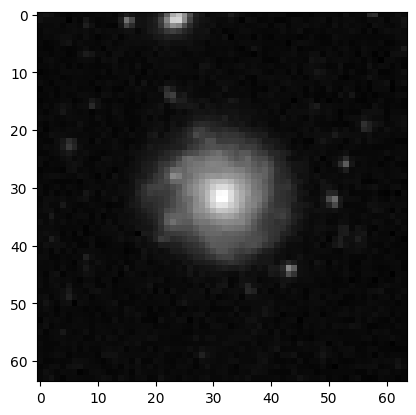

In [55]:
def downsample_image(image, block_size):
    """
    Downsamples an image by averaging over p x p blocks to reduce its dimensions.

    Args:
    image (numpy.ndarray): The input image array.
    block_size (int): The size of each square block used for down-sampling.

    Returns:
    numpy.ndarray: The downsampled image.
    """
    # Compute the new dimensions
    new_height = image.shape[0] // block_size
    new_width = image.shape[1] // block_size

    # Initialize the downsampled image
    downsampled = np.zeros((new_height, new_width))

    # Process each block to create the downsampled image
    for i in range(new_height):
        for j in range(new_width):
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            downsampled[i, j] = block.mean()

    return downsampled



# Define the block size
p = 4 


# Dynamically name the file based on the block size p 
new_file_path = f'/Users/harshitlakum/Desktop/downsampled_images_{p}x{p}.hdf5' #dataset with {p}x{p}




# Apply the down-sampling to each image in the dataset
downsampled_images = np.array([downsample_image(img, p) for img in grayscale_images])


# Save the new downsampled images to a new HDF5 file
with h5py.File('/Users/harshitlakum/Desktop/downsampled_images_{p}x{p}.hdf5', 'w') as f:
    # Create a dataset for storing the downsampled images
    dset = f.create_dataset('downsampled_images', data=downsampled_images, dtype='float64')

    
    dset.attrs['Description'] = 'Downsampled images averaging over p x p pixel blocks'
    dset.attrs['Block_size'] = p
    
    
    
fig = plt.figure() 
plt.imshow(downsampled_images[27,...])
plt.imshow(downsampled_images[0], cmap='gray')
plt.show() # downsampled 

Task 2:

Selecting a galaxy of interest, we performed a wavelet low-rank approximation on its image data. By retaining only 1/4th and then 1/16th of the wavelet coefficients (specifically keeping the 'A' part and discarding all other components), we efficiently reduced the data complexity while maintaining the essential features of the galaxy. This method of approximation significantly compresses the image data, enabling a focus on the most influential features for analysis.

In [56]:
my_selected_image = grayscale_images[25]
cA, (cH, cV, cD) = pywt.dwt2(grayscale_images, 'db2')
cH1 = np.zeros_like(cH)
cV2 = np.zeros_like(cV)
cD3 = np.zeros_like(cD)

In [57]:
def apply_dwt_and_reconstruct(image, fraction):
    # Perform 2D Discrete Wavelet Transform
    cA, (cH, cV, cD) = pywt.dwt2(image, 'db2')
    
    # Zero out all arrays except for cA
    cH1 = np.zeros_like(cH)
    cV2 = np.zeros_like(cV)
    cD3 = np.zeros_like(cD)

    # Optionally reduce coefficients in the approximation matrix
    def reduce_coeffs(coeffs, frac):
        threshold = np.percentile(np.abs(coeffs), 100 * (1 - frac))
        coeffs[np.abs(coeffs) < threshold] = 0
        return coeffs

    cA = reduce_coeffs(cA, fraction)
    # Reconstruct the image from the transformed coefficients
    return pywt.idwt2((cA, (cH1, cV2, cD3)), 'db2')


# Apply the transformations for 1/4 and 1/16 fractions
image_quarter = apply_dwt_and_reconstruct(my_selected_image, 0.25)
image_sixteenth = apply_dwt_and_reconstruct(my_selected_image, 0.0625)


    
    

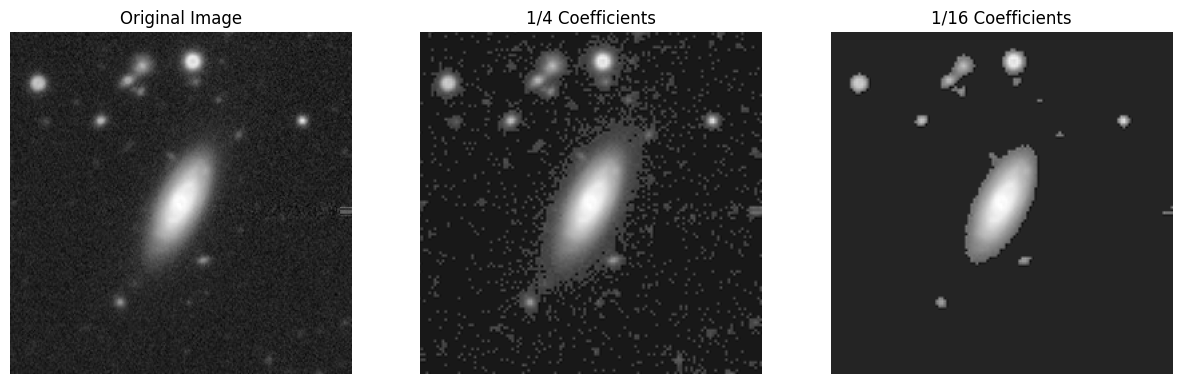

In [58]:
# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(my_selected_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(image_quarter, cmap='gray')
axes[1].set_title('1/4 Coefficients')
axes[1].axis('off')

axes[2].imshow(image_sixteenth, cmap='gray')
axes[2].set_title('1/16 Coefficients')
axes[2].axis('off')

plt.show()

Task 3
Utilizing SVD decomposition, the galaxy image was compressed by retaining only 1/4 and 1/16 of its singular values. Upon comparing these results with the wavelet decomposition, the SVD at 1/16 retained more detailed features than the equivalent wavelet method.

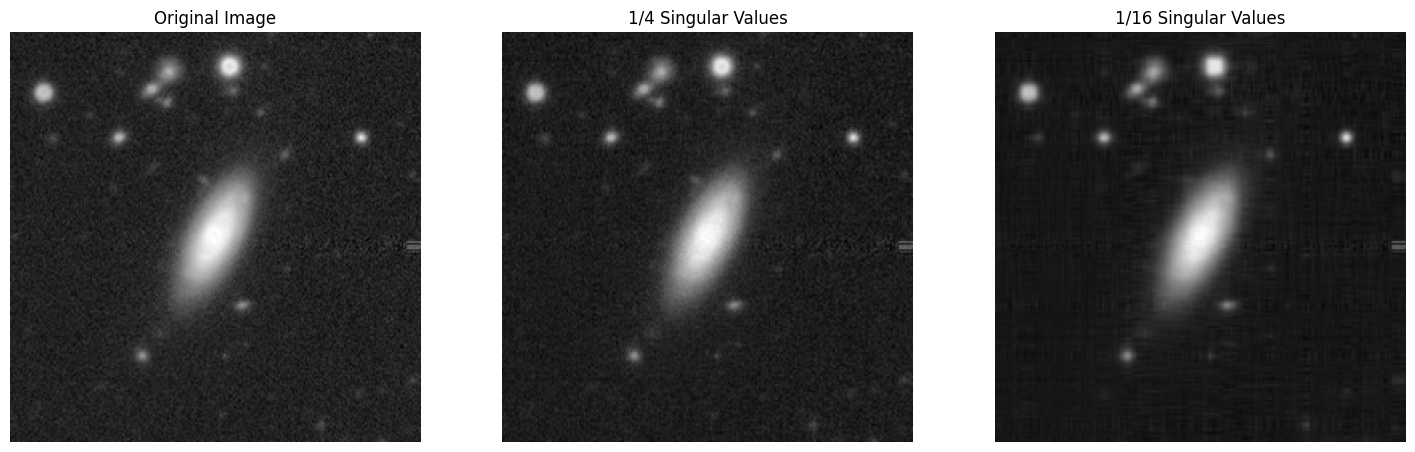

In [59]:
from PIL import Image
my_selected_image = grayscale_images[25]

def compress_image(image, fraction):
    # Perform SVD
    U, S, Vt = np.linalg.svd(image, full_matrices=False)
    
    # Calculate the number of singular values to keep
    num_singular_values = int(len(S) * fraction)
    
    # Zero out all but the top 'num_singular_values' singular values
    S_compressed = np.zeros_like(S)
    S_compressed[:num_singular_values] = S[:num_singular_values]
    
    # Reconstruct the image using the compressed singular values
    S_compressed_matrix = np.diag(S_compressed)
    image_compressed = np.dot(U, np.dot(S_compressed_matrix, Vt))
    
    return image_compressed

# Example usage: Compress the first image in your dataset using 1/4 and 1/16 of the singular values
image_quarter = compress_image(my_selected_image, 0.25)
image_sixteenth = compress_image(my_selected_image, 0.0625)

# Plot the original and compressed images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(my_selected_image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(image_quarter, cmap='gray')
axes[1].set_title('1/4 Singular Values')
axes[1].axis('off')

axes[2].imshow(image_sixteenth, cmap='gray')
axes[2].set_title('1/16 Singular Values')
axes[2].axis('off')

plt.show()


Additionally, we implemented hard thresholding on the singular values, setting the threshold at 1560.21580291578. This method resulted in keeping only about 1.171875% of the singular values. This selective retention focused on the most significant features of the galaxy image, resulting in a compressed version that still preserved essential visual information.

Threshold (tau): 1560.21580291578
Fraction of Singular Values Kept: 0.01171875


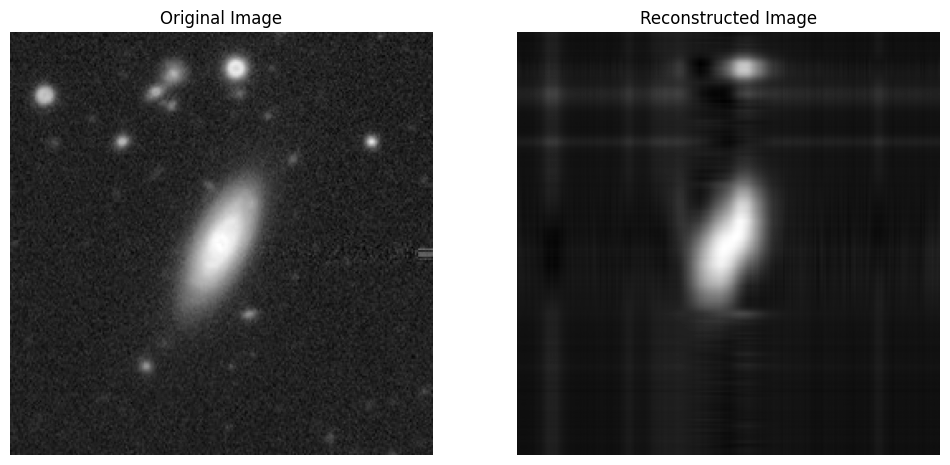

In [60]:
# Hard thrsholding


def apply_svd_and_threshold(image, gamma):
    n = image.shape[0]
    tau = (4 * np.sqrt(n) * gamma) / np.sqrt(3)

    # Perform SVD
    U, S, Vt = np.linalg.svd(image, full_matrices=False)

    # Apply the threshold
    S_thresholded = np.where(S > tau, S, 0)
    fraction_kept = np.sum(S > tau) / len(S)

    # Reconstruct the image using the thresholded singular values
    S_matrix = np.diag(S_thresholded)
    image_reconstructed = np.dot(U, np.dot(S_matrix, Vt))

    return image_reconstructed, fraction_kept, tau




# Calculate the standard deviation of pixel values in the entire image
sigma = np.std(my_selected_image)
noise_pixels = my_selected_image[my_selected_image > 3 * sigma]
gamma = np.std(noise_pixels)
image_reconstructed, fraction_kept, tau = apply_svd_and_threshold(my_selected_image, gamma)

# Print the fraction of singular values kept and the threshold
print("Threshold (tau):", tau)
print("Fraction of Singular Values Kept:", fraction_kept)

# Plotting the original and reconstructed images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(my_selected_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_reconstructed, cmap='gray')
plt.title('Reconstructed Image')
plt.axis('off')

plt.show()

Task 4
We conducted an analysis to find a common basis for images of spiral galaxies using the Singular Value Decomposition (SVD) on the entire dataset, where each flattened image was treated as a row in a matrix (dimension 4096×256, with 4096 features and 256 images). After computing the SVD, we plotted the amplitude of the singular values against their rank to visualize their distribution and significance. Additionally, we displayed the first four singular vectors as images. These vectors (representing singular value U) likely capture the most significant common features or patterns across the spiral galaxy images, such as specific structural characteristics inherent to this type of galaxy. This approach allows us to understand and represent the dataset with fewer dimensions while preserving crucial visual information.

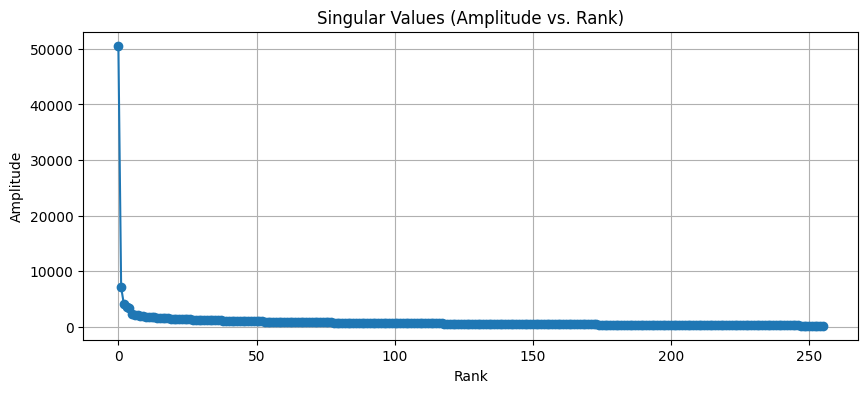

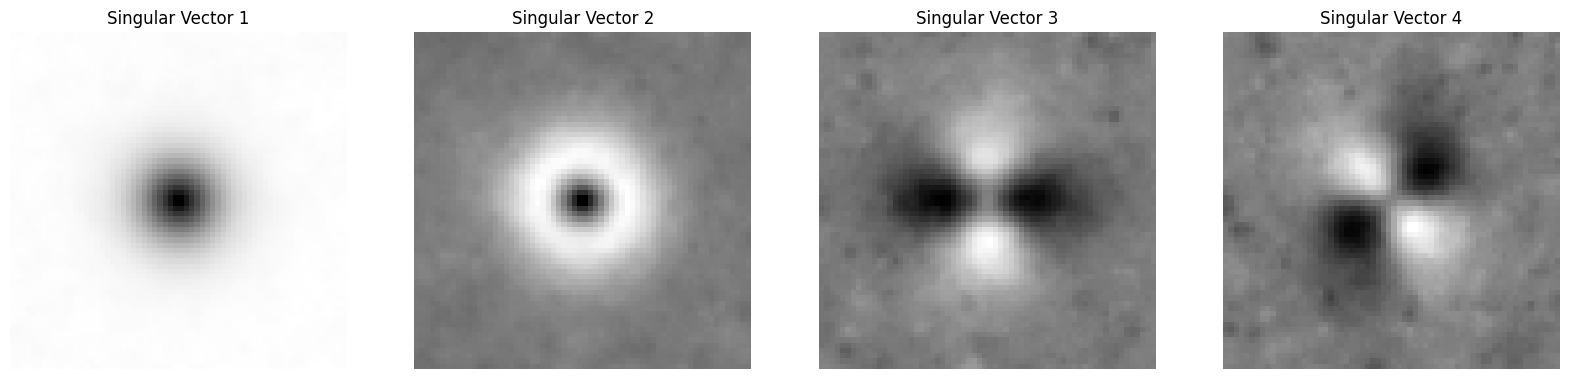

In [ ]:
image_matrix = downsampled_images.reshape(256, -1).T

#  Compute the SVD
U, S, VT = np.linalg.svd(image_matrix, full_matrices=False)

# Plot the singular values
plt.figure(figsize=(10, 4))
plt.plot(S, marker='o')
plt.title("Singular Values (Amplitude vs. Rank)")
plt.xlabel("Rank")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

#  Visualize the first 4 singular vectors
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    ax = axes[i]
    ax.imshow(U[:, i].reshape(64, 64), cmap='gray')  # Reshape each vector back to the size of the original images
    ax.set_title(f"Singular Vector {i+1}")
    ax.axis('off')
    
plt.show()

